In [ ]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.signal import find_peaks

# Cycling data preprocessing

## 0. data load

In [ ]:
def tot_cyc(data_path, data):
  df_l = []
  for idx, val in enumerate(data):
    df = pd.read_csv(data_path + val)
    cyc = df[['TotCycle']].values
    tot_cyc = cyc+(idx*50)
    df['tot_cyc'] = tot_cyc
    df_l.append(df)
  return df_l

In [ ]:
# Cell
cell_1_path = '/home/sbml/BADA/Cell_dataset/Cell_1/'
cell_1 = os.listdir(cell_1_path)
dc1_l = tot_cyc(cell_1_path, cell_1)
dc1 = pd.concat(dc1_l, axis=0)

cell_2_path = '/home/sbml/BADA/Cell_dataset/Cell_2/'
cell_2 = os.listdir(cell_2_path)
dc2_l = tot_cyc(cell_2_path, cell_2)
dc2 = pd.concat(dc2_l, axis=0)

cell_3_path = '/home/sbml/BADA/Cell_dataset/Cell_3/'
cell_3 = os.listdir(cell_3_path)
dc3_l = tot_cyc(cell_3_path, cell_3)
dc3 = pd.concat(dc3_l, axis=0)

# Module
module_path = '/home/sbml/BADA/Module_dataset/'
module = os.listdir(module_path)
dm_l = tot_cyc(module_path, module)
dm = pd.concat(dm_l, axis=0)

In [ ]:
def drop(df):
  d_drop = df[(df['Type']=='방전')& (df['Current(mA)']==0.00)]
  df = df.drop(d_drop.index, axis=0)

  return df

In [ ]:
dc1 = drop(dc1)
dc2 = drop(dc2)
dc3 = drop(dc3)

dm = drop(dm)

In [ ]:
def separate(df):
  #d_full = df[(df['Type']=='충전')| (df['Type']=='방전')]
  d_ch = df[df['Type']=='충전']
  d_dis = df[df['Type']=='방전']
  return d_ch, d_dis

In [ ]:
dc1_ch, dc1_dis = separate(dc1)
dc2_ch ,dc2_dis = separate(dc2)
dc3_ch, dc3_dis = separate(dc3)

dm_ch, dm_dis = separate(dm)

## 1. cycling data

In [ ]:
def cyc_data(df, label):
  data_l = []
  cyc_l = []
  type_l = []
  vol_l = []
  curr_l = []
  cap_l = []
  time_l = []

  cycs = list(set(df['tot_cyc'].tolist()))
  for cyc in cycs:
    d_cyc = df[df['tot_cyc']==cyc]
    vol = np.array(d_cyc['Voltage(mV)'].tolist())*(1/1000)
    curr = np.array(d_cyc['Current(mA)'].tolist())*(1/1000)
    cap = np.array(d_cyc['Capacity(mAh)'].tolist())*(1/1000)
    t = d_cyc['TotTime(sec)'].tolist()
    time = np.array(t) - t[0]

    data_l.append(label)
    cyc_l.append(cyc)
    type_l.append(d_cyc['Type'].tolist())
    vol_l.append(list(vol))
    curr_l.append(list(curr))
    cap_l.append(list(cap))
    time_l.append(list(time))

  df = pd.DataFrame()
  cols = ['dataset', 'cycle', 'type', 'Voltage(V)', 'Current(A)', 'Capacity(Ah)', 'Time(s)']
  val_l = [data_l, cyc_l, type_l, vol_l, curr_l, cap_l, time_l]

  for col, val in zip(cols, val_l):
    df[col] = val
  return df

In [ ]:
# Cell
dc1_cyc_ch = cyc_data(dc1_ch, 'cell_1')
dc1_cyc_dis = cyc_data(dc1_dis, 'cell_1')
dc2_cyc_ch = cyc_data(dc2_ch, 'cell_2')
dc2_cyc_dis = cyc_data(dc2_dis, 'cell_2')
dc3_cyc_ch = cyc_data(dc3_ch, 'cell_3')
dc3_cyc_dis = cyc_data(dc3_dis, 'cell_3')

dc_cyc_ch = pd.concat([dc1_cyc_ch, dc2_cyc_ch, dc3_cyc_ch])
dc_cyc_dis = pd.concat([dc1_cyc_dis, dc2_cyc_dis, dc3_cyc_dis])

# Module
dm_cyc_ch = cyc_data(dm_ch, 'module')
dm_cyc_dis = cyc_data(dm_dis, 'module')

In [ ]:
dc_cyc_ch = dc_cyc_ch.reset_index(drop=True)
dc_cyc_dis = dc_cyc_dis.reset_index(drop=True)

## 2. Incremental Capacity (IC)

In [ ]:
def IC_gen(df):
  ic_l = []
  ic_v_l = []
  for k in range(len(df)):
    cap = df.iloc[k]['Capacity(Ah)']
    vol = df.iloc[k]['Voltage(V)']

    q = []
    v = []
    for j in range(0,len(vol), 50):
      q.append(cap[j])
      v.append(vol[j])

    dq = np.diff(q)
    dv = np.diff(v)
    idx = np.where(dv==0)
    dv[idx]=0.00001

    ic = dq/dv

    idx = np.where(np.round(np.array(v[:-1]),2)==4.2)
    ic = np.delete(ic, idx).tolist()
    ic_v = np.delete(v[:-1], idx).tolist()

    ratio = round(len(ic)*0.03)
    ic = ic[:-ratio]
    ic_v = ic_v[:-ratio]

    ic_l.append(ic)
    ic_v_l.append(ic_v)

  df['IC(Ah/V)'] = ic_l
  df['IC_vol(V)'] = ic_v_l
  return df

In [ ]:
# Cell
dc_ch = IC_gen(dc_cyc_ch)
dc_dis = IC_gen(dc_cyc_dis)

# Module
dm_ch = IC_gen(dm_cyc_ch)
dm_dis = IC_gen(dm_cyc_dis)

## 3. SoH $ dataset

In [ ]:
def soh(df):
  soh_l = []
  init_cap = max(df.iloc[0]['Capacity(Ah)'])
  for k in range(len(df)):
    dis_cap = max(df.iloc[k]['Capacity(Ah)'])
    soh = dis_cap/init_cap
    soh_l.append(soh)
  dsoh = pd.DataFrame()
  dsoh['soh'] = soh_l
  return dsoh

In [ ]:
# Cell
dc_soh = soh(dc_dis)

# Module
dm_soh = soh(dm_dis)

In [ ]:
dc_dataset = dc_cyc_ch[['dataset']]
dm_dataset = dm_cyc_ch[['dataset']]

## 4. cycling profiles

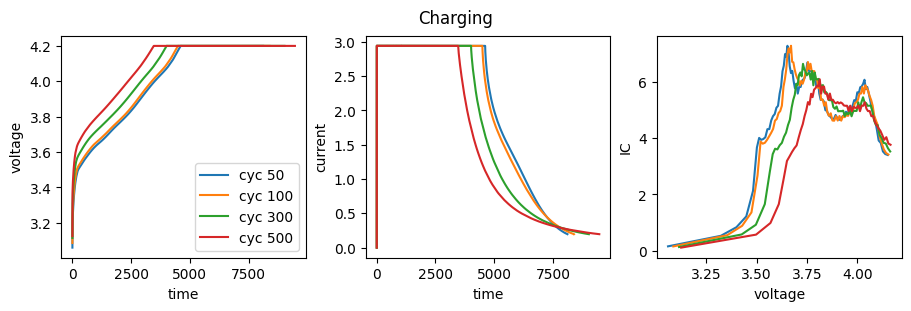

In [ ]:
fig = plt.figure(figsize=(9,3),constrained_layout=True)
fig.suptitle('Charging')
for k in [50, 100, 300, 500]:
  c_t = dc_ch.iloc[k]['Time(s)']
  c_vol = dc_ch.iloc[k]['Voltage(V)']
  c_curr = dc_ch.iloc[k]['Current(A)']
  c_ch_ic = dc_ch.iloc[k]['IC(Ah/V)']
  c_ch_ic_vol = dc_ch.iloc[k]['IC_vol(V)']

  plt.subplot(131)
  plt.plot(c_t, c_vol, label=f'cyc {k}')
  plt.ylabel('voltage')
  plt.xlabel('time')
  plt.legend()
  plt.subplot(132)
  plt.plot(c_t, c_curr, label=f'cyc {k}')
  plt.ylabel('current')
  plt.xlabel('time')
  plt.subplot(133)
  plt.plot(c_ch_ic_vol, c_ch_ic, label=f'cyc {k}')
  plt.ylabel('IC')
  plt.xlabel('voltage')

# Feature extraction

In [ ]:
def smooth(y, box_pts):
  box = np.ones(box_pts)/box_pts
  y_smooth = np.convolve(y, box, mode='same')
  return y_smooth

## 0. Charge-related feature extraction

In [ ]:
dc_ch.columns

Index(['dataset', 'cycle', 'type', 'Voltage(V)', 'Current(A)', 'Capacity(Ah)',
       'Time(s)', 'IC(Ah/V)', 'IC_vol(V)'],
      dtype='object')

In [ ]:
df = dm_ch
c = 7 # cell=1 / module=7

# feature_names
ch_v_start, ch_v_area, ch_v_slope, ch_v_std, ch_v_skew, ch_v_kurt = [], [], [], [], [], []
ch_v_nplt_end, ch_v_nplt_area, ch_v_nplt_slope, ch_v_nplt_std, ch_v_nplt_skew, ch_v_nplt_kurt = [], [], [], [], [], []
ch_I_nplt_start, ch_I_nplt_start_time, ch_I_nplt_end, ch_I_nplt_end_time = [], [], [] ,[]
ch_I_nplt_area, ch_I_nplt_slope, ch_I_nplt_skew, ch_I_nplt_kurt = [], [], [], []
ch_IC_start, ch_IC_area, ch_IC_std, ch_IC_skew, ch_IC_kurt = [], [], [], [], []
ch_IC_peak1, ch_IC_peak1_v, ch_IC_peak2, ch_IC_peak2_v, ch_IC_peak3, ch_IC_peak3_v = [], [], [], [], [], []
ch_IC_min_peak1, ch_IC_min_peak1_v, ch_IC_min_peak2, ch_IC_min_peak2_v = [], [], [], []

for i in range(len(df)):
  vol = df.iloc[i]['Voltage(V)']
  curr = df.iloc[i]['Current(A)']
  time = df.iloc[i]['Time(s)']
  ic = df.iloc[i]['IC(Ah/V)']
  ic_vol = df.iloc[i]['IC_vol(V)']

  ## Voltage
  ch_v_start.append(vol[0])
  ch_v_area.append(sum(vol))
  ch_v_slope.append((vol[-1]-vol[0])/(time[-1]-time[0]))
  ch_v_std.append(np.std(vol))
  ch_v_skew.append(skew(vol))
  ch_v_kurt.append(kurtosis(vol))

  ### before plateau
  for v in vol:
    if v > 4.199:
        idx = vol.index(v)
        break
  vol_nplt = vol[:idx]
  time_nplt= time[:idx]

  ch_v_nplt_end.append(vol_nplt[-1])
  ch_v_nplt_area.append(sum(vol_nplt))
  ch_v_nplt_slope.append((vol_nplt[-1]-vol_nplt[0])/(time_nplt[-1]-time_nplt[0]))
  ch_v_nplt_std.append(np.std(vol_nplt))
  ch_v_nplt_skew.append(skew(vol_nplt))
  ch_v_nplt_kurt.append(kurtosis(vol_nplt))


  ## Current

  ### before plateau
  for I in curr[1:]:
    #if round(I,2) < 2.94: # cell
    if round(I,1) < 20.0: # module
        idx = curr.index(I)
        break
  curr_nplt = curr[:idx]
  time_nplt = time[:idx]

  ch_I_nplt_start.append(curr_nplt[0]/c) #/7 for module
  ch_I_nplt_start_time.append(time_nplt[0])
  ch_I_nplt_end.append(curr_nplt[-1]/c)
  ch_I_nplt_end_time.append(time_nplt[-1])
  ch_I_nplt_area.append(sum(curr_nplt)/c)
  ch_I_nplt_slope.append(((curr_nplt[-1]-curr_nplt[0])/(time_nplt[-1]-time_nplt[0]))/c)
  ch_I_nplt_skew.append(skew(curr_nplt))
  ch_I_nplt_kurt.append(kurtosis(curr_nplt)/c)


  ## IC
  ### raw
  ch_IC_start.append(ic[0]/c)
  ch_IC_area.append(sum(ic)/c)
  ch_IC_std.append(np.std(ic)/c)
  ch_IC_skew.append(skew(ic))
  ch_IC_kurt.append(kurtosis(ic)/c)

  ### positive peaks
  target = ic + ic[-5:]
  smooth_ic = smooth(target, 5)[:-5]
  #peaks, properties = find_peaks(smooth_ic, height=4, width=4) # cell
  peaks, properties = find_peaks(smooth_ic, height=30, width=4) # module
  ch_IC_peak1.append(smooth_ic[peaks[0]]/c)
  ch_IC_peak1_v.append(ic_vol[peaks[0]])
  if len(peaks) == 1:
    ch_IC_peak2.append(ch_IC_peak2[-1])
    ch_IC_peak2_v.append(ch_IC_peak2_v[-1])
    ch_IC_peak3.append(ch_IC_peak3[-1])
    ch_IC_peak3_v.append(ch_IC_peak3_v[-1])
  elif len(peaks) == 2:
    ch_IC_peak2.append(smooth_ic[peaks[-1]]/c)
    ch_IC_peak2_v.append(ic_vol[peaks[-1]])
    ch_IC_peak3.append(ch_IC_peak3[-1])
    ch_IC_peak3_v.append(ch_IC_peak3_v[-1])
  elif len(peaks) == 3:
    ch_IC_peak2.append(smooth_ic[peaks[1]]/c)
    ch_IC_peak2_v.append(ic_vol[peaks[1]])
    ch_IC_peak3.append(smooth_ic[peaks[-1]]/c)
    ch_IC_peak3_v.append(ic_vol[peaks[-1]])

  ### negative peaks
  target = ic + ic[-5:]
  smooth_ic = smooth(target, 5)[:-5]*(-1)
  #peaks, properties = find_peaks(smooth_ic, height=(-7,-4), width=5) # cell
  peaks, properties = find_peaks(smooth_ic, height=(-50, -30), width=5) # module
  if len (peaks) == 0:
    ch_IC_min_peak1.append(ch_IC_min_peak1[-1])
    ch_IC_min_peak1_v.append(ch_IC_min_peak1_v[-1])
    ch_IC_min_peak2.append(ch_IC_min_peak2[-1])
    ch_IC_min_peak2_v.append(ch_IC_min_peak2_v[-1])
  elif len(peaks) == 1:
    ch_IC_min_peak1.append(smooth_ic[peaks[-1]]/c)
    ch_IC_min_peak1_v.append(ic_vol[peaks[-1]])
    ch_IC_min_peak2.append(ch_IC_min_peak2[-1])
    ch_IC_min_peak2_v.append(ch_IC_min_peak2[-1])
  elif len(peaks) == 2:
    ch_IC_min_peak1.append(smooth_ic[peaks[0]]/c)
    ch_IC_min_peak1_v.append(ic_vol[peaks[0]])
    ch_IC_min_peak2.append(smooth_ic[peaks[-1]]/c)
    ch_IC_min_peak2_v.append(ic_vol[peaks[-1]])

  if len(ch_IC_peak2) != len(ch_IC_peak1_v):
    print(i)

<ipython-input-27-547a04e9471b>:100: PeakPropertyWarning: some peaks have a width of 0
  peaks, properties = find_peaks(smooth_ic, height=(-50, -30), width=5) # module
<ipython-input-27-547a04e9471b>:77: PeakPropertyWarning: some peaks have a width of 0
  peaks, properties = find_peaks(smooth_ic, height=30, width=4) # module


In [ ]:
keys = ['v_start', 'v_area', 'v_slope', 'v_std', 'v_skew', 'v_kurt', 'v_nplt_end', 'v_nplt_area',
          'v_nplt_slope', 'v_nplt_std', 'v_nplt_skew', 'v_nplt_kurt',
          'I_nplt_start', 'I_nplt_start_time', 'I_nplt_end' , 'I_nplt_end_time',
            'I_nplt_area', 'I_nplt_slope', 'I_nplt_skew', 'I_nplt_kurt',
          'IC_start', 'IC_area', 'IC_std', 'IC_skew', 'IC_kurt',
           'IC_peak1', 'IC_peak1_v', 'IC_peak2', 'IC_peak2_v', 'IC_peak3', 'IC_peak3_v',
           'IC_min_peak1', 'IC_min_peak1_v', 'IC_min_peak2', 'IC_min_peak2_v']

In [ ]:
values = [ch_v_start, ch_v_area, ch_v_slope, ch_v_std, ch_v_skew, ch_v_kurt,
    ch_v_nplt_end, ch_v_nplt_area, ch_v_nplt_slope, ch_v_nplt_std, ch_v_nplt_skew, ch_v_nplt_kurt,
    ch_I_nplt_start, ch_I_nplt_start_time, ch_I_nplt_end, ch_I_nplt_end_time,
    ch_I_nplt_area, ch_I_nplt_slope, ch_I_nplt_skew, ch_I_nplt_kurt,
    ch_IC_start, ch_IC_area, ch_IC_std, ch_IC_skew, ch_IC_kurt,
    ch_IC_peak1, ch_IC_peak1_v, ch_IC_peak2, ch_IC_peak2_v, ch_IC_peak3, ch_IC_peak3_v,
    ch_IC_min_peak1, ch_IC_min_peak1_v, ch_IC_min_peak2, ch_IC_min_peak2_v]

In [ ]:
# Cells
dc_ch_ft = pd.DataFrame()
for i in range(len(keys)):
  dc_ch_ft[keys[i]] = values[i]

In [ ]:
# Module
dm_ch_ft = pd.DataFrame()
for i in range(len(keys)):
  dm_ch_ft[keys[i]] = values[i]

## 1. Discharge-related feature extraction

In [ ]:
dc_dis.columns

Index(['dataset', 'cycle', 'type', 'Voltage(V)', 'Current(A)', 'Capacity(Ah)',
       'Time(s)', 'IC(Ah/V)', 'IC_vol(V)', 'SoH'],
      dtype='object')

In [ ]:
df = dm_dis
c = 7 # cell=1 / module=7

# feature_names
dis_v_start, dis_v_duration, dis_v_end, dis_v_area, dis_v_slope, dis_v_std, dis_v_skew, dis_v_kurt = [], [], [], [], [], [], [], []
dis_I_slope = []
dis_IC_start, dis_IC_start_v, dis_IC_end, dis_IC_end_v, dis_IC_area, dis_IC_std, dis_IC_skew, dis_IC_kurt = [], [], [], [], [], [], [], []
dis_IC_peak1, dis_IC_peak1_v, dis_IC_peak2, dis_IC_peak2_v, dis_IC_peak3, dis_IC_peak3_v = [], [], [], [], [], []
dis_IC_min_peak1, dis_IC_min_peak1_v, dis_IC_min_peak2, dis_IC_min_peak2_v = [], [], [], []



for i in range(len(df)):
  voltage = df.iloc[i]['Voltage(V)']
  current = df.iloc[i]['Current(A)']
  time = df.iloc[i]['Time(s)']
  ic = (np.array(df.iloc[i]['IC(Ah/V)'])*(-1)).tolist()
  ic_vol = df.iloc[i]['IC_vol(V)']


  ## Volatge
  dis_v_start.append(voltage[0])
  dis_v_duration.append(time[-1]-time[0])
  dis_v_end.append(voltage[-1])
  dis_v_area.append(sum(voltage))
  dis_v_slope.append((voltage[-1]-voltage[0])/(time[-1]-time[0]))
  dis_v_std.append(np.std(voltage))
  dis_v_skew.append(skew(voltage))
  dis_v_kurt.append(kurtosis(voltage))


  ## Current
  dis_I_slope.append(((current[-1]-current[0])/(time[-1]-time[0]))/c)  # 7 for module


  ##IC
  dis_IC_start.append(ic[0]/c)
  dis_IC_start_v.append(ic_vol[0])
  dis_IC_end.append(ic[-1]/c)
  dis_IC_end_v.append(ic_vol[-1])
  dis_IC_area.append(sum(ic)/c)
  dis_IC_std.append(np.std(ic)/c)
  dis_IC_skew.append(skew(ic))
  dis_IC_kurt.append(kurtosis(ic)/c)

  ### positive peaks
  target = ic + ic[-5:]
  ic_smooth = smooth(target, 5)[:-5]
  #peaks, properties = find_peaks(ic_smooth, height=3, width=8) # cell
  peaks, properties = find_peaks(ic_smooth, height=20, width=8) # module
  dis_IC_peak1.append(ic_smooth[peaks[0]]/c)
  dis_IC_peak1_v.append(ic_vol[peaks[0]])
  if len(peaks) == 1:
    dis_IC_peak2.append(dis_IC_peak2[-1])
    dis_IC_peak2_v.append(dis_IC_peak2_v[-1])
    dis_IC_peak3.append(dis_IC_peak3[-1])
    dis_IC_peak3_v.append(dis_IC_peak3_v[-1])
  elif len(peaks) == 2:
    dis_IC_peak2.append(ic_smooth[peaks[-1]]/c)
    dis_IC_peak2_v.append(ic_vol[peaks[-1]])
    dis_IC_peak3.append(dis_IC_peak3[-1])
    dis_IC_peak3_v.append(dis_IC_peak3_v[-1])
  if len(peaks) == 3:
    dis_IC_peak2.append(ic_smooth[peaks[1]]/c)
    dis_IC_peak2_v.append(ic_vol[peaks[1]])
    dis_IC_peak3.append(ic_smooth[peaks[-1]]/c)
    dis_IC_peak3_v.append(ic_vol[peaks[-1]])

  ### negative peaks
  target = ic + ic[-5:]
  ic_smooth = smooth(target, 5)[:-5]*(-1)
  #peaks, properties = find_peaks(ic_smooth, height=(-7, -3), width=8) # cell
  peaks, properties = find_peaks(ic_smooth, height=(-50,-20), width=8) # module
  if len(peaks) == 0:
    dis_IC_min_peak1.append(dis_IC_min_peak1[-1])
    dis_IC_min_peak1_v.append(dis_IC_min_peak1_v[-1])
    dis_IC_min_peak2.append(dis_IC_min_peak2[-1])
    dis_IC_min_peak2_v.append(dis_IC_min_peak2_v[-1])
  elif len(peaks) == 1:
    dis_IC_min_peak1.append(ic_smooth[peaks[0]]/c)
    dis_IC_min_peak1_v.append(ic_vol[peaks[0]])
    dis_IC_min_peak2.append(dis_IC_min_peak2[-1])
    dis_IC_min_peak2_v.append(dis_IC_min_peak2_v[-1])
  elif len(peaks) == 2:
    dis_IC_min_peak1.append(ic_smooth[peaks[0]]/c)
    dis_IC_min_peak1_v.append(ic_vol[peaks[0]])
    dis_IC_min_peak2.append(ic_smooth[peaks[-1]]/c)
    dis_IC_min_peak2_v.append(ic_vol[peaks[-1]])

<ipython-input-36-af6466f7387d>:50: PeakPropertyWarning: some peaks have a width of 0
  peaks, properties = find_peaks(ic_smooth, height=20, width=8) # module


In [ ]:
keys = ['dis_v_start', 'dis_v_duration', 'dis_v_end', 'dis_v_area', 'dis_v_slope', 'dis_v_std', 'dis_v_skew', 'dis_v_kurt',
'dis_I_slope',
'dis_IC_start', 'dis_IC_start_v', 'dis_IC_end', 'dis_IC_end_v', 'dis_IC_area', 'dis_IC_std', 'dis_IC_skew', 'dis_IC_kurt',
'dis_IC_peak1', 'dis_IC_peak1_v', 'dis_IC_peak2', 'dis_IC_peak2_v', 'dis_IC_peak3', 'dis_IC_peak3_v',
'dis_IC_min_peak1', 'dis_IC_min_peak1_v', 'dis_IC_min_peak2', 'dis_IC_min_peak2_v']

In [ ]:
values = [ dis_v_start, dis_v_duration, dis_v_end, dis_v_area, dis_v_slope, dis_v_std, dis_v_skew, dis_v_kurt,
dis_I_slope,
dis_IC_start, dis_IC_start_v, dis_IC_end, dis_IC_end_v, dis_IC_area, dis_IC_std, dis_IC_skew, dis_IC_kurt,
dis_IC_peak1, dis_IC_peak1_v, dis_IC_peak2, dis_IC_peak2_v, dis_IC_peak3, dis_IC_peak3_v,
dis_IC_min_peak1, dis_IC_min_peak1_v, dis_IC_min_peak2, dis_IC_min_peak2_v]

In [ ]:
# Cells
dc_dis_ft = pd.DataFrame()
for i in range(len(keys)):
  dc_dis_ft[keys[i]] = values[i]

In [ ]:
# Module
dm_dis_ft = pd.DataFrame()
for i in range(len(keys)):
  dm_dis_ft[keys[i]] = values[i]

In [ ]:
dc_ft = pd.concat([dc_dataset, dc_dis_ft, dc_ch_ft, dc_soh], axis=1)
dm_ft = pd.concat([dm_dataset, dm_dis_ft, dm_ch_ft, dm_soh], axis=1)

In [ ]:
pd.set_option('display.max_columns', None)
dc_ft

,dataset,dis_v_start,dis_v_duration,dis_v_end,dis_v_area,dis_v_slope,dis_v_std,dis_v_skew,dis_v_kurt,dis_I_slope,dis_IC_start,dis_IC_start_v,dis_IC_end,dis_IC_end_v,dis_IC_area,dis_IC_std,dis_IC_skew,dis_IC_kurt,dis_IC_peak1,dis_IC_peak1_v,dis_IC_peak2,dis_IC_peak2_v,dis_IC_peak3,dis_IC_peak3_v,dis_IC_min_peak1,dis_IC_min_peak1_v,dis_IC_min_peak2,dis_IC_min_peak2_v,v_start,v_area,v_slope,v_std,v_skew,v_kurt,v_nplt_end,v_nplt_area,v_nplt_slope,v_nplt_std,v_nplt_skew,v_nplt_kurt,I_nplt_start,I_nplt_start_time,I_nplt_end,I_nplt_end_time,I_nplt_area,I_nplt_slope,I_nplt_skew,I_nplt_kurt,IC_start,IC_area,IC_std,IC_skew,IC_kurt,IC_peak1,IC_peak1_v,IC_peak2,IC_peak2_v,IC_peak3,IC_peak3_v,IC_min_peak1,IC_min_peak1_v,IC_min_peak2,IC_min_peak2_v,soh
0,cell_1,4.129429,7088.80,2.499752,25575.035695,-0.000230,0.298261,-0.592762,0.129517,-3.119005e-07,0.637341,4.129429,0.795655,3.034057,740.166293,2.100239,0.400197,0.796808,10.494266,3.971470,6.640597,3.785390,6.133128,3.487649,-3.581963,3.889920,-4.548696,3.624075,3.410747,29391.040607,0.000108,0.222661,-0.674057,-1.006326,4.198685,15980.907549,0.000190,0.186413,0.038041,-1.077033,0.0,0.0,2.939886,4157.0,12221.590686,0.000707,-64.458365,4152.920682,0.408621,409.699706,1.077880,-1.390140,2.970901,6.142110,3.656335,6.375195,3.753963,5.830379,4.023224,-5.494419,3.691411,-4.725088,3.895507,1.000000
1,cell_1,4.129829,7085.70,2.499775,25570.128106,-0.000230,0.297841,-0.592729,0.139710,-3.569160e-07,0.636369,4.129829,0.769459,3.035452,739.997049,2.084144,0.378589,0.796047,10.423522,3.971715,6.641697,3.780623,6.172786,3.488047,-3.597169,3.880817,-4.534489,3.624503,3.029119,31221.355453,0.000149,0.254745,-0.705927,-0.699459,4.198994,17836.765041,0.000250,0.216604,-0.188411,-0.573425,0.0,0.0,2.940046,4690.0,13788.609771,0.000627,-68.467895,4685.901847,0.160163,458.222170,1.343939,-1.586801,3.119126,6.783204,3.634963,6.388482,3.749671,5.864735,4.025406,-5.580904,3.680723,-4.746292,3.889671,0.999562
2,cell_1,4.129615,7083.55,2.499877,25563.182716,-0.000230,0.297997,-0.597999,0.150223,-2.895441e-07,0.634470,4.129615,0.763811,3.033006,739.625118,2.084010,0.364420,0.750408,10.343203,3.968309,6.630230,3.781003,6.145269,3.488150,-3.609091,3.881065,-4.535560,3.624559,3.027832,31170.454124,0.000149,0.254975,-0.704659,-0.699423,4.198974,17823.599940,0.000250,0.216737,-0.189391,-0.569308,0.0,0.0,2.939946,4687.0,13779.789199,0.000627,-68.446216,4682.923097,0.160046,457.530921,1.344858,-1.582278,3.085407,6.766972,3.628824,6.407722,3.749506,5.870444,4.025393,-5.604104,3.687693,-4.734251,3.898238,0.999259
3,cell_1,4.129680,7079.70,2.499746,25550.418776,-0.000230,0.297955,-0.599122,0.153480,-2.785429e-07,0.633702,4.129680,0.755937,3.030004,738.772020,2.082163,0.360128,0.779832,10.395195,3.975020,6.685642,3.781304,6.183119,3.493565,-3.614442,3.881064,-4.544045,3.624622,3.025987,31149.055381,0.000149,0.255294,-0.705234,-0.697240,4.198817,17802.006145,0.000251,0.216939,-0.190777,-0.565615,0.0,0.0,2.939628,4683.0,13768.023799,0.000628,-68.416643,4678.891478,0.159787,456.536994,1.344576,-1.579570,3.053022,6.754707,3.634286,6.373601,3.755700,5.862489,4.032408,-5.577198,3.687372,-4.719944,3.898480,0.998717
4,cell_1,4.129395,7075.55,2.499896,25536.604940,-0.000230,0.298096,-0.600826,0.155097,-3.153112e-07,0.630812,4.129395,0.748477,3.026684,738.679528,2.094857,0.382852,0.802865,10.537577,3.971766,6.636417,3.781704,6.129794,3.493234,-3.627788,3.881215,-4.550108,3.624589,3.025974,31168.374530,0.000149,0.255152,-0.707327,-0.693926,4.198972,17783.492589,0.000251,0.216798,-0.191243,-0.563089,0.0,0.0,2.940086,4677.0,13750.398369,0.000629,-68.372689,4672.883200,0.159485,452.829026,1.347839,-1.590246,3.140842,6.775570,3.640682,6.415000,3.743495,5.869980,4.026000,-5.578828,3.680348,-4.718828,3.890245,0.998132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

### c. Save

In [ ]:
dc_ft.to_csv('/home/sbml/BADA/cells_features.csv', index=False)
dm_ft.to_csv('/home/sbml/BADA/7p_features.csv', index=False)